#### Developed by AI GDE [Nitin Tiwari](https://linkedin.com/in/tiwari-nitin).
* LinkedIn: [linkedin.com/in/tiwari-nitin](https://linkedin.com/in/tiwari-nitin)
* GitHub: [github.com/NSTiwari](https://github.com/NSTiwari)
* X: [@NSTiwari21](https://x.com/NSTiwari21)


This notebook is an implementation of referring expression segmentation for any object using Gemini 2.5 models.


<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/NSTiwari/Segmentation-using-Gemini/blob/main/Segmentation_using_Gemini.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

#### Step 1: Install Gen-AI SDK.

In [1]:
%pip install -U -q google-genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 7.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-server 1.24.0 requires anyio<4,>=3.1.0, but you have anyio 4.9.0 which is incompatible.


#### Step 2: Import libraries

In [4]:
import cv2
import numpy as np
from PIL import Image
from google.colab import userdata
from google import genai
from google.genai import types
import random
import base64
from IPython.display import Markdown, HTML
from base64 import b64encode
import json
import io
from io import BytesIO

#### Step 3: Configure Gemini API Key and model parameters.

In [6]:
# Configure Gemini API Key
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
client = genai.Client(api_key=GOOGLE_API_KEY)

model_name = "gemini-2.5-pro-exp-03-25"  # @param ["gemini-1.5-flash-latest","gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-pro-exp-03-25"] {"allow-input":true}

bounding_box_system_instructions = """
    Return bounding boxes as a JSON array with labels. Never return masks or code fencing. Limit to 25 objects.
    If an object is present multiple times, name them according to their unique characteristic (colors, size, position, unique characteristics, etc..).
"""

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]


#### Step 4: Pass input image and text prompt

In [ ]:
# Download sample images and videos.
!wget https://raw.githubusercontent.com/NSTiwari/Segmentation-using-Gemini/main/assets/image_1.png -O /content/image_1.png
!wget https://raw.githubusercontent.com/NSTiwari/Segmentation-using-Gemini/main/assets/image_2.png -O /content/image_2.png
!wget https://raw.githubusercontent.com/NSTiwari/Segmentation-using-Gemini/main/assets/video.mp4 -O /content/image_3.png

In [8]:
input_type = 'image'  # @param ['image', 'video']

image_path = 'image_1.png' # @param {type : 'string'}
video_path = 'video.mp4' # @param {type : 'string'}

object_to_segment = "A person giving talk"  # @param {type : 'string'}
prompt = f"Give the segmentation masks for {object_to_segment}. Output a JSON list of segmentation masks where each entry contains the 2D bounding box in the key 'box_2d', the segmentation mask in key 'mask', and the text label in the key 'label'."


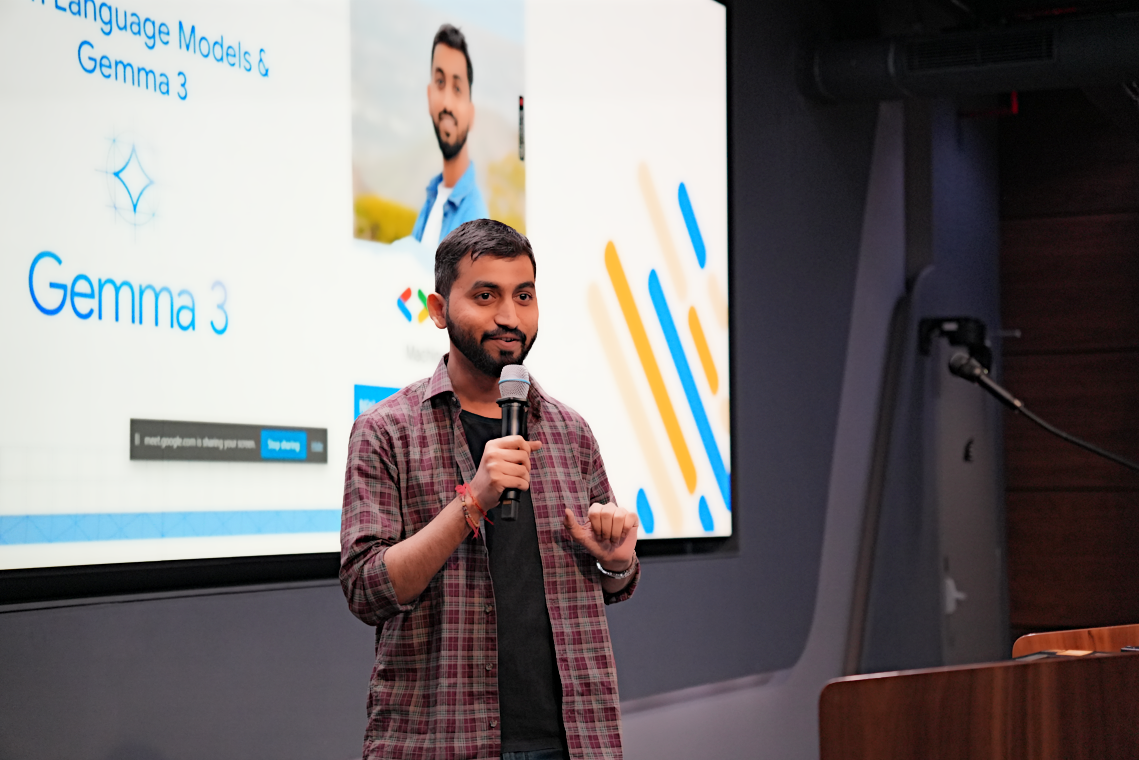

In [11]:
img = Image.open(image_path)
display(img)

#### Step 5: Parse JSON response and generate segmentation masks

In [21]:
def parse_json(text: str) -> str:
    return text.strip().removeprefix("```json").removesuffix("```")

def generate_mask(predicted_str: str, *, img_height: int, img_width: int) -> list[tuple[np.ndarray, str]]:
    try:
        items = json.loads(parse_json(predicted_str))
        if not isinstance(items, list):
            print("Error: Parsed JSON is not a list.")
            return []
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        print(f"Problematic string snippet: {predicted_str[:200]}...")
        return []
    except Exception as e:
        print(f"An unexpected error occurred during JSON parsing: {e}")
        return []

    segmentation_data = []
    default_label = "unknown"

    for item_idx, item in enumerate(items):
        if not isinstance(item, dict) or "box_2d" not in item or "mask" not in item:
            print(f"Skipping invalid item structure at index {item_idx}: {item}")
            continue

        label = item.get("label", default_label)
        if not isinstance(label, str) or not label:
            label = default_label

        png_str = item["mask"]
        if not isinstance(png_str, str) or not png_str.startswith("data:image/png;base64,"):
            print(f"Skipping item {item_idx} (label: {label}) with invalid mask format.")
            continue
        png_str = png_str.removeprefix("data:image/png;base64,")
        try:
            png_bytes = base64.b64decode(png_str)
            bbox_mask = cv2.imdecode(np.frombuffer(png_bytes, np.uint8), cv2.IMREAD_GRAYSCALE)
            if bbox_mask is None:
                print(f"Skipping item {item_idx} (label: {label}) because mask decoding failed.")
                continue
        except (base64.binascii.Error, ValueError, Exception) as e:
            print(f"Error decoding base64 or image data for item {item_idx} (label: {label}): {e}")
            continue

        try:
            box = item["box_2d"]
            if not isinstance(box, list) or len(box) != 4:
                print(f"Skipping item {item_idx} (label: {label}) with invalid box_2d format: {box}")
                continue
            y0_norm, x0_norm, y1_norm, x1_norm = map(float, box)
            abs_y0 = max(0, min(int(y0_norm / 1000.0 * img_height), img_height - 1))
            abs_x0 = max(0, min(int(x0_norm / 1000.0 * img_width), img_width - 1))
            abs_y1 = max(0, min(int(y1_norm / 1000.0 * img_height), img_height))
            abs_x1 = max(0, min(int(x1_norm / 1000.0 * img_width), img_width))
            bbox_height = abs_y1 - abs_y0
            bbox_width = abs_x1 - abs_x0
            if bbox_height <= 0 or bbox_width <= 0:
                print(f"Skipping item {item_idx} (label: {label}) with invalid bbox dims: {box} -> ({bbox_width}x{bbox_height})")
                continue
        except (ValueError, TypeError) as e:
            print(f"Skipping item {item_idx} (label: {label}) due to error processing box_2d: {e}")
            continue

        try:
            if bbox_mask.shape[0] > 0 and bbox_mask.shape[1] > 0:
                resized_bbox_mask = cv2.resize(
                    bbox_mask, (bbox_width, bbox_height), interpolation=cv2.INTER_LINEAR
                )
            else:
                print(f"Skipping item {item_idx} (label: {label}) due to empty decoded mask before resize.")
                continue
        except cv2.error as e:
            print(f"Error resizing mask for item {item_idx} (label: {label}): {e}")
            continue

        full_mask = np.zeros((img_height, img_width), dtype=np.uint8)
        try:
            full_mask[abs_y0:abs_y1, abs_x0:abs_x1] = resized_bbox_mask
        except ValueError as e:
            print(f"Error placing mask for item {item_idx} (label: {label}): {e}. Shape mismatch: slice=({bbox_height},{bbox_width}), resized={resized_bbox_mask.shape}. Attempting correction.")
            try:
                resized_bbox_mask_corrected = cv2.resize(bbox_mask, (bbox_width, bbox_height), interpolation=cv2.INTER_LINEAR)
                full_mask[abs_y0:abs_y1, abs_x0:abs_x1] = resized_bbox_mask_corrected
                print("  -> Corrected placement.")
            except Exception as inner_e:
                print(f"  -> Failed to correct placement: {inner_e}")
                continue

        segmentation_data.append((full_mask, label))

    return segmentation_data

def generate_random_color() -> np.ndarray:
    return np.array([random.randint(0, 255) for _ in range(3)], dtype=np.float32)

# Function to overlay segmentation masks onto the image or video frame.
def overlay_masks(
    img: Image.Image,
    segmentation_data: list[tuple[np.ndarray, str]],
    alpha: float = 0.8,
    label_to_color: dict = None
) -> np.ndarray:
    if not (0.0 <= alpha <= 1.0):
        raise ValueError("Alpha must be between 0.0 and 1.0")

    img_np_rgb = np.array(img.convert('RGB'))
    img_np_bgr = cv2.cvtColor(img_np_rgb, cv2.COLOR_RGB2BGR)

    if not segmentation_data:
        return img_np_bgr

    overlay_img = img_np_bgr.copy()
    beta = 1.0 - alpha

    for i, (mask, label) in enumerate(segmentation_data):
        if mask is None or mask.shape != (overlay_img.shape[0], overlay_img.shape[1]):
            print(f"Skipping invalid or mismatched mask at index {i} (label: {label})")
            continue

        # Assign a random color if not already assigned.
        if label not in label_to_color:
            label_to_color[label] = generate_random_color()

        color_bgr = label_to_color[label]
        boolean_mask = mask > 127

        if not np.any(boolean_mask):
            continue

        current_pixels = overlay_img[boolean_mask].astype(np.float32)
        blended_pixels = (color_bgr * alpha) + (current_pixels * beta)
        blended_pixels_uint8 = np.clip(blended_pixels, 0, 255).astype(np.uint8)
        overlay_img[boolean_mask] = blended_pixels_uint8

    return overlay_img

label_to_color = {}

# Load image or video based on user selection.
if input_type == 'image':
    im = Image.open(image_path)

    # Run model and overlay segmentation masks.
    img_height, img_width = im.size[1], im.size[0]
    response = client.models.generate_content(
        model=model_name,
        contents=[prompt, im],
        config=types.GenerateContentConfig(
            temperature=0.5,
            safety_settings=safety_settings,
        )
    )
    result = response.text
    segmentation_data = generate_mask(result, img_height=img_height, img_width=img_width)

    # Overlay masks and save result.
    if segmentation_data:
        segmentation_output = overlay_masks(im, segmentation_data, alpha=0.6, label_to_color=label_to_color)
        segmentation_image_output = Image.fromarray(cv2.cvtColor(segmentation_output, cv2.COLOR_BGR2RGB))
        segmentation_image_output.save("output_image.png")
        segmentation_image_output.show()

else:
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter("output_video.mp4", fourcc, fps, (frame_width, frame_height))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        im = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        response = client.models.generate_content(
            model=model_name,
            contents=[prompt, im],
            config=types.GenerateContentConfig(
                temperature=0.5,
                safety_settings=safety_settings,
            )
        )
        result = response.text
        segmentation_data = generate_mask(result, img_height=frame_height, img_width=frame_width)

        if segmentation_data:
            frame_with_overlay = overlay_masks(im, segmentation_data, alpha=0.6, label_to_color=label_to_color)
        else:
            frame_with_overlay = frame

        out.write(frame_with_overlay)

    cap.release()
    out.release()

    print("Video processing complete. Output saved to output_video.mp4")


#### Step 6: Display final segmentation output

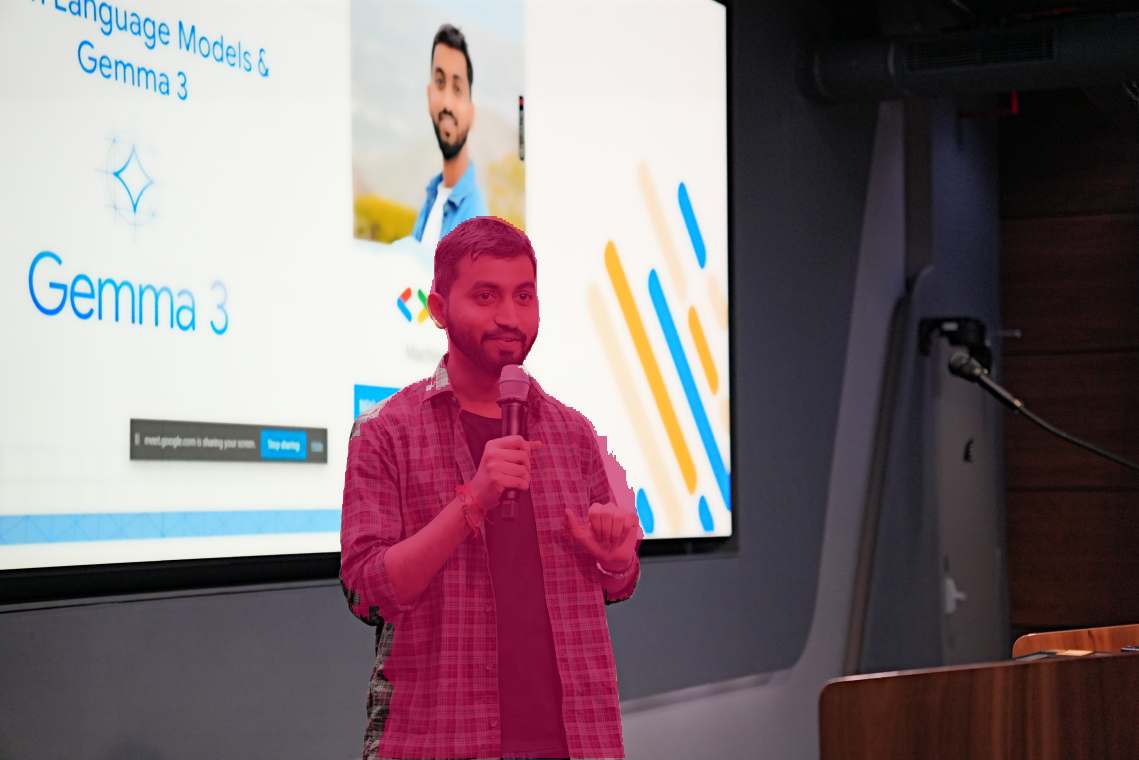

In [24]:
display(segmentation_image_output)